In [2]:
import torch 
import torch.nn as nn
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image
from torchvision import transforms

In [3]:
class CNNDoubleConv(nn.Module):
    def __init__(self, input_size=(32, 32)):
        super(CNNDoubleConv, self).__init__()
        
        self.features = nn.Sequential(
            nn.Conv2d(1, 16, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.Conv2d(16, 32, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2),

            nn.Conv2d(32, 64, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.Conv2d(64, 128, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2),
        )
        
        with torch.no_grad():
            dummy_input = torch.zeros(1, 1, *input_size)  # Adjust input channels if needed
            flattened_size = self.features(dummy_input).numel()

        self.classifier = nn.Sequential(
            nn.Flatten(),
            nn.Linear(flattened_size, 128),
            nn.ReLU(),
            nn.Linear(128, 1),
            nn.Sigmoid(),
        )

    def forward(self, x):
        features = self.features(x)
        output = self.classifier(features)
        return output

    def extract_features(self, x):
        return self.features(x)

In [4]:
model = CNNDoubleConv(input_size=(32, 32))
model.load_state_dict(torch.load(f"pretrained/saved/{type(model).__name__}_e10.pth", weights_only=True))
model.eval()

CNNDoubleConv(
  (features): Sequential(
    (0): Conv2d(1, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU()
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU()
    (7): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU()
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (classifier): Sequential(
    (0): Flatten(start_dim=1, end_dim=-1)
    (1): Linear(in_features=8192, out_features=128, bias=True)
    (2): ReLU()
    (3): Linear(in_features=128, out_features=1, bias=True)
    (4): Sigmoid()
  )
)

In [5]:
def occlusion_sensitivity(model, img, label_idx=None, mask_size=8, stride=4):
    
    _, _, H, W = img.shape
    heatmap = np.zeros((H, W))
    
    with torch.no_grad():
        original_output = model(img)
        if label_idx is None:
            label_idx = original_output.argmax().item()
        original_score = original_output[0, label_idx].item()
    
    for h in range(0, H, stride):
        for w in range(0, W, stride):
            occluded_img = img.clone()
            occluded_img[:, :, h:h+mask_size, w:w+mask_size] = 0
            with torch.no_grad():
                occluded_output = model(occluded_img)
                occluded_score = occluded_output[0, label_idx].item()

            heatmap[h:h+mask_size, w:w+mask_size] += original_score - occluded_score
    
    heatmap = np.maximum(heatmap, 0)
    heatmap /= heatmap.max()
    return heatmap

In [6]:
FOLDER_PATH = "../data_students/labeled_data/Img_test/"

preprocess = transforms.Compose([
    transforms.Resize((32, 32)),
    transforms.ToTensor(),
    # transforms.Normalize(mean=[0.5], std=[0.5])
])

[tensor([[0.0806]]), tensor([[0.0868]]), tensor([[0.0811]]), tensor([[0.0841]]), tensor([[0.0846]]), tensor([[0.0805]])]


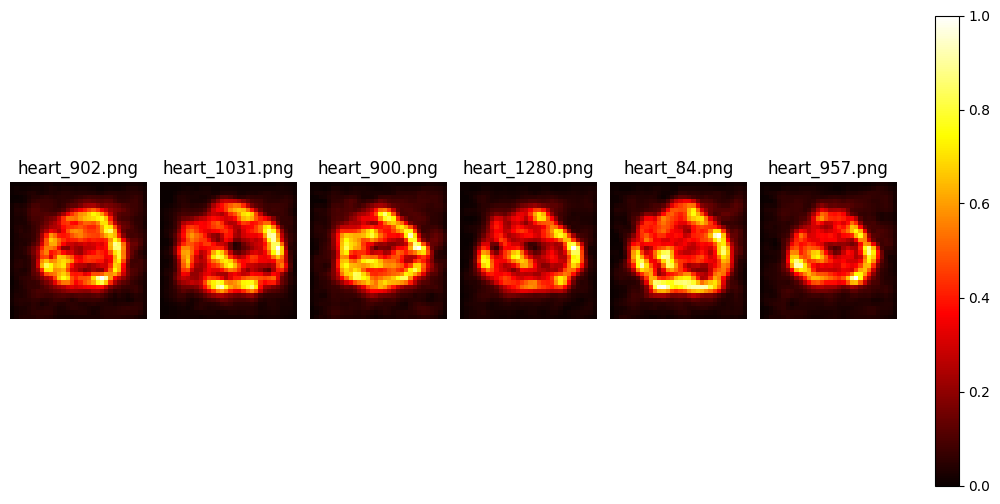

In [8]:
images_ids = [902,1031,900,1280,84,957]
predictions = []

fig, axes = plt.subplots(1, len(images_ids), figsize=(10, 5), tight_layout=True)

for idx, i in enumerate(images_ids):
    img = Image.open(f"{FOLDER_PATH}heart_{i}.png")
    img_tensor = preprocess(img)
    img_tensor = img_tensor.unsqueeze(0)

    with torch.no_grad():
        output = model(img_tensor)
    predictions.append(output)

    heatmap = occlusion_sensitivity(model, img_tensor, mask_size=2, stride=1)
    ax = axes[idx]
    im = ax.imshow(heatmap, cmap='hot', interpolation='nearest')
    ax.set_title(f"heart_{i}.png")
    ax.axis('off')

print(predictions)

plt.tight_layout()
plt.colorbar(im, 
    ax=axes.ravel().tolist(), 
    orientation='vertical', 
    fraction=0.046, 
    pad=0.04
)
plt.show()

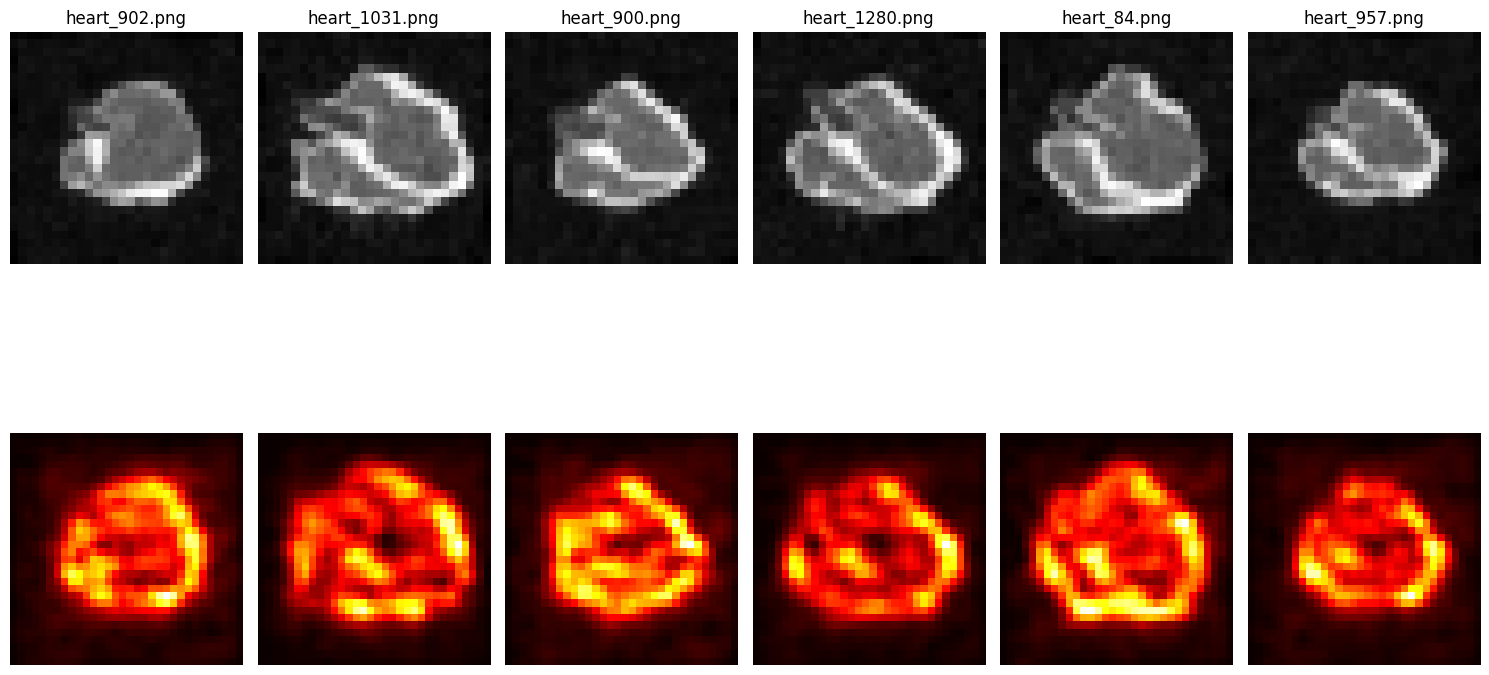

[tensor([[0.0806]]), tensor([[0.0868]]), tensor([[0.0811]]), tensor([[0.0841]]), tensor([[0.0846]]), tensor([[0.0805]])]


In [ ]:
images_ids = [902, 1031, 900, 1280, 84, 957]
predictions = []

fig, axes = plt.subplots(2, len(images_ids), figsize=(15, 10), tight_layout=True)  # 2 rows: one for images, one for heatmaps

for idx, i in enumerate(images_ids):
    img = Image.open(f"{FOLDER_PATH}heart_{i}.png")
    img_tensor = preprocess(img)
    img_tensor = img_tensor.unsqueeze(0)

    with torch.no_grad():
        output = model(img_tensor)
    predictions.append(output)

    ax_img = axes[0, idx]
    ax_img.imshow(img, cmap='gray')
    ax_img.set_title(f"heart_{i}.png")
    ax_img.axis('off')

    heatmap = occlusion_sensitivity(model, img_tensor, mask_size=2, stride=1)
    ax_heatmap = axes[1, idx]
    im = ax_heatmap.imshow(heatmap, cmap='hot', interpolation='nearest')
    ax_heatmap.axis('off')

plt.tight_layout()
plt.show()

print(predictions)
